<font size="7"><center>Flight Fare Prediction</center></font>


<font size="6"><center> **Neural Network Model**</center></font>

---

<div class="alert alert-warning">
    
<font size="2">__Author__: -  Kasun Malwenna</font>

<font size="2">__Contact__: - kasunmalwenna@gmail.com</font>
    
---
    
This notebook only consists of modelling and evaluating Deep Learning model using the cleaned version of the data. 

For cleaning and preprocessing steps, refer to **"_Data_Wrangling_and_EDA__Kasun_Malwenna.ipynb_"** notebook. For Machine Learning models, refer to **"_Modeling_Flight_Fare_Kasun_Malwenna.ipynb_"** notebook.

This notebook’s outputs cannot be reproduced unless run in a specific Colab environment.
    
---  
</div>


># Working In Google Colab

Neural Network is essentially several basic ML models strung together that have excellent predictive capabilities and can handle both structured and unstructured data. 
An NN architecture comprises an inter-connected Input layer, hidden layers and an output layer. 

Parameters of NN refer to the weights of the connection between these layers, and weights are learned and tuned during the learning stage of the model. The computational complexity of a NN can greatly increase with the increase in the number of parameters. Therefore, NN can greatly benefit from using faster GPUs during training.

Google Colab is a could service that offers a variety of computer resources such as faster CPUs, GPUs and RAMs and a jupyter notebook style environment for machine learning tasks. We will use Colab and their premium GPUs to train our NN model efficiently.

First, we need to enable GPUs in Colab by changing the runtime to “Premium GPU”. Then we are required to use TensorFlow 2.10.0 which is the only version that supports GPUs.

In [1]:
# Check if we are connected to a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 12 02:02:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Instale tensofor gpu version in colab environment
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 5.9 MB 75.5 MB/s 
     |████████████████████████████████| 438 kB 92.0 MB/s 
     |████████████████████████████████| 1.7 MB 85.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

In [3]:
# Import tensorflow and check version.
import tensorflow as tf
print(tf.__version__)

2.10.0


Now, let’s import the required packages and libraries.

In [4]:
# Importing standard data science libraries 
import pandas as pd
import numpy as np

# Importing visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import the scalers
from sklearn.preprocessing import StandardScaler

# Importing required tensorflow moules
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

# Importing required library to save and load models
import joblib

# Import required colab modules to import and load data to a dataframe
from google.colab import files
import io

---
># Pre-modeling Stage

Since we are working in a cloud setting, we have to use Colabs built-in functions to upload and load the dataset.

In [5]:
# Uploading the train and test data
uploaded = files.upload()

Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


In [7]:
# Loading the datasets into dataframes
train_df = pd.read_csv(io.BytesIO(uploaded['train_data.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['test_data.csv']))

In [8]:
# Defining the dependent and independent variables for train and test sets

X_train= train_df.drop(columns= ['price']) # independent
y_train = train_df['price']                # dependent

X_test= test_df.drop(columns= ['price'])   # independent
y_test = test_df['price']   

In [9]:
# Check shapes
print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (240207, 22)
y_train shape (240207,)
X_test shape (60052, 22)
y_test shape (60052,)


Since NN is a decent-based algorithm, it is always best practice to scale the data first to remove any arbitrary effects from differences in feature scale.

In [10]:
# Scale data using StandardScaler

# Instantiate and fit the scaler
ss = StandardScaler()
ss.fit(X_train)

# Transform the data
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

We will also use the same metrics and evaluation function for this model. However, we will rename the evaluation function to avoid any conflicts that may arise since TensorFlow already has a built-in “evaluate” method.

In [11]:
# Difining a function to evaluate the models

def evaluate_NN(model, X_test, y_test, X_train, y_train): # Renamed the previously used function
    
    # Empty list to record metrics
    performance_metrics = []
    
    # ake predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Append model name
    performance_metrics.append(model)
    
    print('Model Performance')
    print('-----------------')
    
    from sklearn import metrics
    
    # coefficient of determination
    train_r2 = round(metrics.r2_score(y_train,y_pred_train),4)
    print(f"Train set R2 score: {train_r2}")
    test_r2 = round(metrics.r2_score(y_test,y_pred_test),4)
    performance_metrics.append(test_r2)
    print(f"Test R2 score: {test_r2}")
    
    # Adjusted r2
    # Define variables to calculate adjusted r2 score
    r2 = metrics.r2_score(y_test,y_pred_test) #The R2 of the model
    n = len(y_test)                      #The number of observations
    k = X_test.shape[1]                  #The number of predictor variables
    
    # calculate adjusted r2 score
    adj_r2_score = round(1-(((1-r2)*(n-1))/(n-k-1)),4)
    performance_metrics.append(adj_r2_score)
    print(f"Test set Adjusted R2 score: {adj_r2_score}")
    
    # Root Mean Squared Error
    RMSE = round(metrics.mean_squared_error(y_test,y_pred_test, squared=False),4)
    performance_metrics.append(RMSE)
    print(f"Test set Root Mean Squared Error - RMSE: {RMSE}")
    
    # Mean Absolute Error
    MAE = round(metrics.mean_absolute_error(y_test,y_pred_test),4)
    performance_metrics.append(MAE)
    print(f"Test set Mean Absolute Error - MAE: {MAE}")
    
    # Mean Absolute Precentage Error
    MAPE = round(metrics.mean_absolute_percentage_error(y_test, y_pred_test),4)
    performance_metrics.append(MAPE)
    print(f"Test set Mean Absolute Precentage Error - MAPE: {MAPE}")
    
    return performance_metrics

---
># Model Building and Evaluation

First, let’s build a basic NN with an input layer of 32 nodes and one hidden layer of 512 nodes. We will use the “Relu” activation function as it is the most commonly used activation. For the output, we do not need to specify an activation, as the default output layer is linearly activated and returns a continuous value. However, we are sure our output variable ("price") can not be a negative value. Therefore we can you “Relu” for output activation as well.

There are four steps in building a Neural Network

__Step 1__ Build the model

In [ ]:
tf.random.set_seed(123) # for consistent results

# Create a new sequential model
NN_baseline_model = keras.Sequential()

# Declare the input layer
NN_baseline_model.add(layers.Dense(32, activation='relu', input_shape= (22,),  name='layer1'))

# Declare the hidden layer
NN_baseline_model.add(layers.Dense(512, activation='relu', name='hidden1'))
NN_baseline_model.add(layers.Dropout(0.2)),


# Declare the output layer
NN_baseline_model.add(layers.Dense(1, activation='relu', name='output')) # ReLU since price cannot have negative values



Let’s look at the structure of our model and how many trainable parameters we can optimize the model on. Higher the number of trainable params, the better predictive accuracy we will have.

In [ ]:
# Looking at model summary
NN_baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 32)                736       
                                                                 
 hidden1 (Dense)             (None, 512)               16896     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output (Dense)              (None, 1)                 513       
                                                                 
Total params: 18,145
Trainable params: 18,145
Non-trainable params: 0
_________________________________________________________________


__Step 2__ Compile the model 

model compile is the step where we define the optimizer and the loss function to optimize the model on.

optimizers are Classes or methods used to change the attributes of our (weights and learning rates) model to minimize the loss. Choosing the optimizer can mean a good result in seconds, hours or days.  Adam optimizer calls for fewer trainable parameters and has faster compute times with good accuracy. Therefore, it is recommended as a default for most of the problems.

Since we are dealing with larger target values, the mean squared error (MSE) can be large. Therefore, we will use mean absolute error (MAE) as the loss function and monitor the MAPE and MSE.


In [ ]:
# Compile the model
NN_baseline_model.compile( 
  optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
  loss=keras.losses.MeanAbsoluteError(), # Loss function to minimize
  metrics=['mape', 'mse'] # metrics
  )

__Step 3__ Train the model

Similar to training ML models, we will only train the NN on train data.

There are a number of parameters we can specify during the fitting of the model;
- epochs - Number of repetitions of adjusting weights, calculation activations and making predictions
- validation_split - separate a portion of the training data to evaluate the model after each epoch

In [ ]:
%%time
# Train the model on train set
history = NN_baseline_model.fit(X_train_ss, y_train, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
6006/6006 [==============================] - 22s 3ms/step - loss: 8231.1699 - mape: 58.4944 - mse: 193757440.0000 - val_loss: 4586.5234 - val_mape: 30.4509 - val_mse: 52995784.0000
Epoch 2/100
6006/6006 [==============================] - 18s 3ms/step - loss: 4242.5098 - mape: 29.5121 - mse: 45142108.0000 - val_loss: 3810.9514 - val_mape: 27.0230 - val_mse: 37043516.0000
Epoch 3/100
6006/6006 [==============================] - 18s 3ms/step - loss: 3794.8801 - mape: 28.7423 - mse: 35654164.0000 - val_loss: 3515.4058 - val_mape: 25.9989 - val_mse: 31988406.0000
Epoch 4/100
6006/6006 [==============================] - 18s 3ms/step - loss: 3676.2976 - mape: 28.9890 - mse: 33140130.0000 - val_loss: 3409.6172 - val_mape: 25.4941 - val_mse: 30600478.0000
Epoch 5/100
6006/6006 [==============================] - 18s 3ms/step - loss: 3609.2087 - mape: 28.8767 - mse: 31960438.0000 - val_loss: 3335.2556 - val_mape: 24.8591 - val_mse: 29734974.0000
Epoch 6/100
6006/6006 [================

Once the training is complete. we can visualize the history in a line plot.

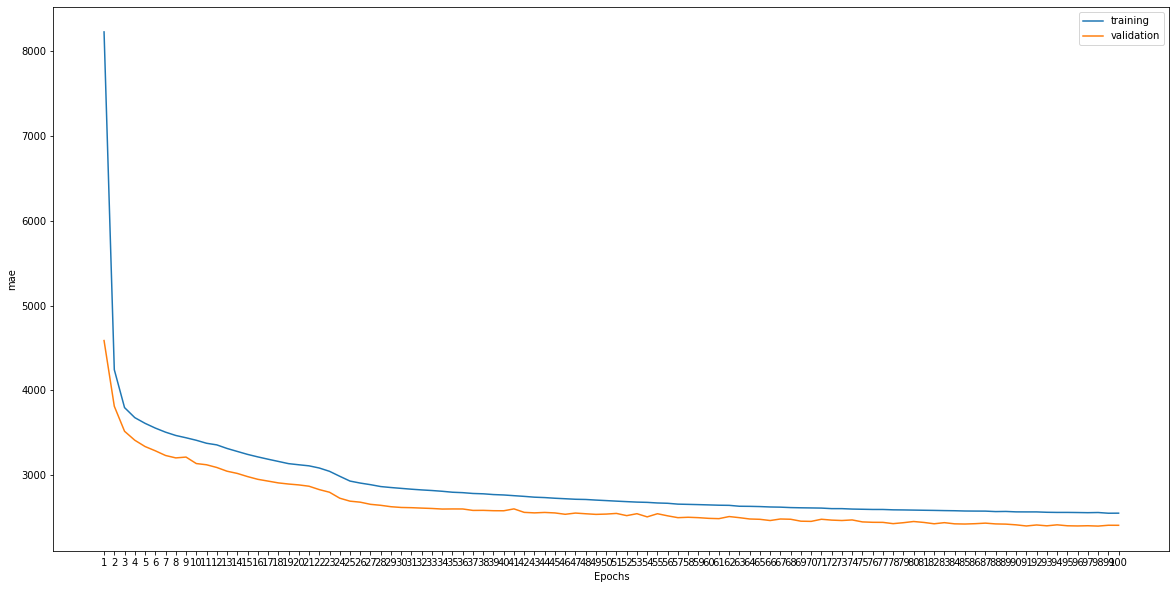

In [ ]:
# Plot loss vs epoch
epochs = range(1, 101)
plt.figure(figsize=(20, 10))

plt.plot(epochs, history.history["loss"], label="training")
plt.plot(epochs, history.history["val_loss"], label="validation")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("mae")
plt.legend()

__Training Observations__
- Losses of our model (MAE) kept minimizing for each epoch trained.
- We observe diminishing returns after a certain number of epochs.
- After 100 epochs our model has MAE $\approx$ 2500 for both training and validation.


__Step 4__ Evaluate the model using the test data

In [ ]:
%%time
# Score the model
NN_baseline_model_performance = evaluate_NN(NN_baseline_model, X_test_ss, y_test, X_train_ss, y_train)

1877/1877 [==============================] - 2s 1ms/step
Model Performance
-----------------
Train set R2 score: 0.9582
Test R2 score: 0.9581
Test set Adjusted R2 score: 0.9581
Test set Root Mean Squared Error - RMSE: 4638.6431
Test set Mean Absolute Error - MAE: 2403.2708
Test set Mean Absolute Precentage Error - MAPE: 0.1633
CPU times: user 18.6 s, sys: 1.94 s, total: 20.5 s
Wall time: 15.7 s


Our baseline model performance is good with high R2 scores and no indication of overfitting. We have a MAE of 16.33% which is not good enough. (Goal is it have it below 10%)

Let’s improve our model by increasing the nodes and adding more hidden layers.

In [32]:
tf.random.set_seed(123) # for consistent results

# Create a new sequential model
NN_model_1 = keras.Sequential()

# Declare the input layer
NN_model_1.add(layers.Dense(512, activation='relu', input_shape= (22,),  name='layer1'))

# Add a dropout layer
NN_model_1.add(layers.Dropout(0.2))

# Declare hidden layers
NN_model_1.add(layers.Dense(256, activation='relu',  name='layer2'))
NN_model_1.add(layers.Dense(128, activation='relu',  name='layer3'))


# Declare the output layer
NN_model_1.add(layers.Dense(1, activation='relu', name='output')) # ReLU since price cannot have negative values

# Compile the model
NN_model_1.compile( 
  optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
  loss=keras.losses.MeanAbsoluteError(), # Loss function to minimize
  metrics=['mape', 'mse'] # metrics
  )

In [33]:
# Looking at model structure
NN_model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 512)               11776     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 layer2 (Dense)              (None, 256)               131328    
                                                                 
 layer3 (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 176,129
Trainable params: 176,129
Non-trainable params: 0
_________________________________________________________________


We now have a vast number of trainable parameters (176,129) compared to the baseline model of 18,145 params. This should increase the performance. Since this will be a computationally intensive process, let’s first train for 20 epochs and inspect for undesirable behaviors.

In [34]:
%%time
# Train the model on train set
history_1 = NN_model_1.fit(X_train_ss, y_train, epochs=20, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/20
6006/6006 [==============================] - 20s 3ms/step - loss: 5231.2329 - mape: 34.6677 - mse: 83823096.0000 - val_loss: 3899.1799 - val_mape: 24.8171 - val_mse: 43765064.0000
Epoch 2/20
6006/6006 [==============================] - 19s 3ms/step - loss: 3564.0820 - mape: 24.1146 - mse: 35324348.0000 - val_loss: 2926.7478 - val_mape: 18.8475 - val_mse: 25417396.0000
Epoch 3/20
6006/6006 [==============================] - 19s 3ms/step - loss: 2980.8223 - mape: 20.0733 - mse: 26086488.0000 - val_loss: 2670.4138 - val_mape: 18.2613 - val_mse: 22381088.0000
Epoch 4/20
6006/6006 [==============================] - 19s 3ms/step - loss: 2812.1023 - mape: 18.6538 - mse: 24278104.0000 - val_loss: 2555.4634 - val_mape: 16.8204 - val_mse: 21496810.0000
Epoch 5/20
6006/6006 [==============================] - 19s 3ms/step - loss: 2719.2236 - mape: 17.9210 - mse: 23383910.0000 - val_loss: 2472.2458 - val_mape: 16.2448 - val_mse: 20827900.0000
Epoch 6/20
6006/6006 [=======================

We observe training loss is higher than the validation loss which is a sign of underfitting. This may be due to the dropout layer we added in order to prevent overfitting. We can reduce the number of dropouts or remove the dropout layer to reduce underfitting. Another reason can be the val loss is calculated at the end of an epoch and train loss is calculated on average, at half an epoch during training.

Let’s remove the dropout layer and train the model for 20 epochs to see if it improved the model.

In [37]:
tf.random.set_seed(123) # for consistent results

# Create a new sequential model
NN_model_2 = keras.Sequential()

# Declare the hidden layers
NN_model_2.add(layers.Dense(512, activation='relu', input_shape= (22,),  name='layer1'))

NN_model_2.add(layers.Dense(256, activation='relu',  name='layer2'))

NN_model_2.add(layers.Dense(128, activation='relu',  name='layer3'))


# Declare the output layer
NN_model_2.add(layers.Dense(1, activation='relu', name='output')) # ReLU since price cannot have negative values

# Compile the model
NN_model_2.compile( 
  optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
  loss=keras.losses.MeanAbsoluteError(), # Loss function to minimize
  metrics=['mape', 'mse'] # metrics
  )

In [38]:
%%time
history_2 = NN_model_2.fit(X_train_ss, y_train, epochs=20, validation_split=0.2, verbose=1, batch_size=32)

Epoch 1/20
6006/6006 [==============================] - 19s 3ms/step - loss: 4849.7427 - mape: 32.2375 - mse: 75521640.0000 - val_loss: 3176.5156 - val_mape: 21.4043 - val_mse: 29155808.0000
Epoch 2/20
6006/6006 [==============================] - 18s 3ms/step - loss: 2904.2742 - mape: 20.1978 - mse: 25124092.0000 - val_loss: 2693.1582 - val_mape: 18.3811 - val_mse: 23001872.0000
Epoch 3/20
6006/6006 [==============================] - 19s 3ms/step - loss: 2623.0564 - mape: 18.3667 - mse: 22064052.0000 - val_loss: 2544.1821 - val_mape: 18.2963 - val_mse: 20649852.0000
Epoch 4/20
6006/6006 [==============================] - 18s 3ms/step - loss: 2483.4817 - mape: 17.3006 - mse: 20775316.0000 - val_loss: 2535.6499 - val_mape: 16.6183 - val_mse: 21098692.0000
Epoch 5/20
6006/6006 [==============================] - 19s 3ms/step - loss: 2388.8943 - mape: 16.4586 - mse: 19959116.0000 - val_loss: 2300.2046 - val_mape: 15.9183 - val_mse: 19128014.0000
Epoch 6/20
6006/6006 [=======================

Training and validation losses are approximately similar after removing the dropout layer. We will continue to train the model without dropout layers as it seems unnecessary.

## Using Callbacks

There are objects in Keras called 'Callbacks' that will perform various acts during the training stage. Let’s employ them to efficiently train our model.

`EarlyStopping`

NN training is a demanding time-consuming process as the number of epochs increases. Early stopping will monitor the desired metric ('val_loss' for our model) and terminate training when there is no significant improvement.

Importance parameters of __EarlyStopping__;
- __*monitor*__ - Metric to be monitored
- __*mode*__ - Tells if the metric monitored should decrease or increase to terminate training. 'min' for regression, 'max' for classification
- __*patience*__ - Number of epochs with no improvement after which training will be stopped.

`ReduceLROnPlateau`

Models often improve with low learning rates. This callback monitors the improvement of the metric and reduces the learning rate if there is no improvement seen for a predefined number of epochs.


Importance parameters of __ReduceLROnPlateau__;
- __*monitor*__ - Metric to be monitored.
- __*factor*__ - the amount by which the learning rate will reduce if there is no improvement.
- __*mode*__ - Tells if the metric monitored should decrease or increase to consider reducing learning rate. 'min' for regression, 'max' for classification
- __*patience*__ - Number of epochs with no improvement after which the learning rate will reduce.
- __*min_delta*__ - Threshold value. If there is no improvement larger than threshold for number of epochs specified at 'patience', the learning rate will be reduced.

`ModelChekpoint`

Save the model weights at an interval such that the model and weights can be loaded later to continue training.

Importance parameters of __ModelChekpoint__;
- __*monitor*__ - Metric to be monitored
- __*mode*__ - Tells if the metric monitored should decrease or increase to be considered as the best model. 'min' for regression, 'max' for classification
- __*save_best_only*__ -Boolean value. If True, only saves the model when it is considered best.

In [39]:
# Define Early stopping callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [40]:
# Define learning rate reducer callback
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [41]:
# Definre model checkpoint callback
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [42]:
%%time
# Training previous model with the call bascks for 500 epochs
history_2 = NN_model_2.fit(X_train_ss, y_train, epochs=500, validation_split=0.2, verbose=1, callbacks=[early_stop, model_checkpoint, reduce_lr_loss], batch_size=32)

Epoch 1/500
6000/6006 [============================>.] - ETA: 0s - loss: 1886.6660 - mape: 13.0527 - mse: 14547877.0000
Epoch 1: val_loss improved from inf to 1883.53870, saving model to best_model.h5
6006/6006 [==============================] - 19s 3ms/step - loss: 1886.9519 - mape: 13.0523 - mse: 14555265.0000 - val_loss: 1883.5387 - val_mape: 13.0702 - val_mse: 14230620.0000 - lr: 0.0010
Epoch 2/500
5993/6006 [============================>.] - ETA: 0s - loss: 1873.2155 - mape: 12.9301 - mse: 14411472.0000
Epoch 2: val_loss improved from 1883.53870 to 1857.26001, saving model to best_model.h5
6006/6006 [==============================] - 19s 3ms/step - loss: 1872.4855 - mape: 12.9278 - mse: 14400681.0000 - val_loss: 1857.2600 - val_mape: 12.8565 - val_mse: 14207587.0000 - lr: 0.0010
Epoch 3/500
5992/6006 [============================>.] - ETA: 0s - loss: 1855.7560 - mape: 12.8165 - mse: 14172805.0000
Epoch 3: val_loss did not improve from 1857.26001
6006/6006 [========================

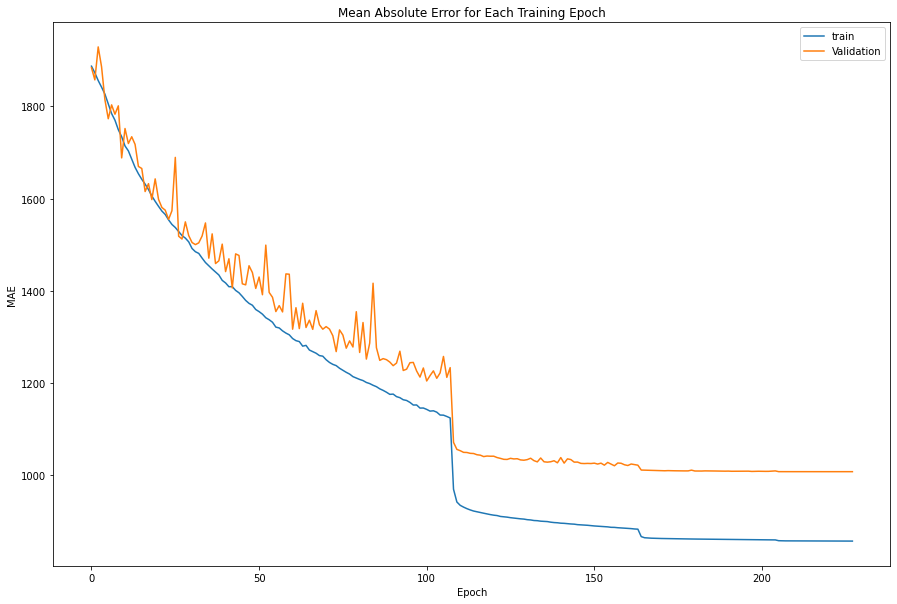

In [52]:
# plot training history
plt.figure(figsize=(15,10))
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='Validation')
plt.title('Mean Absolute Error for Each Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

__Training Observations__
- Model training terminated at 228 epochs with a training time of 1 hour and 11 minutes using premium GPUs.
- Learning rate was reduced twice and no improvement recorded after a learning rate of $1 x {10^-}{^6}$.

In [44]:
%%time
# Evaluate the model
NN_model_2_performance = evaluate_NN(NN_model_2, X_test_ss, y_test, X_train_ss, y_train)

1877/1877 [==============================] - 3s 1ms/step
Model Performance
-----------------
Train set R2 score: 0.9861
Test R2 score: 0.9839
Test set Adjusted R2 score: 0.9839
Test set Root Mean Squared Error - RMSE: 2873.8085
Test set Mean Absolute Error - MAE: 1024.4848
Test set Mean Absolute Precentage Error - MAPE: 0.0713
CPU times: user 21 s, sys: 2.19 s, total: 23.2 s
Wall time: 18.3 s


Model is performing extremely well with high R2 scores and low errors scores compared to other models and managed to achieve a MAPE of 7.13%.

In [43]:
# Saving the model
joblib.dump(NN_model_2, 'NN_model_2.pkl')

['NN_model_2.pkl']

In [47]:
Best_NN_model = joblib.load('NN_model_2.pkl')

In [48]:
%%time
Best_NN_performance = evaluate_NN(Best_NN_model, X_test_ss, y_test, X_train_ss, y_train)

1877/1877 [==============================] - 3s 1ms/step
Model Performance
-----------------
Train set R2 score: 0.9861
Test R2 score: 0.9839
Test set Adjusted R2 score: 0.9839
Test set Root Mean Squared Error - RMSE: 2873.8085
Test set Mean Absolute Error - MAE: 1024.4848
Test set Mean Absolute Precentage Error - MAPE: 0.0713
CPU times: user 20.3 s, sys: 1.98 s, total: 22.2 s
Wall time: 16.9 s


Let’s add more layers to see if we can surpass the best lowest MAPE achieved (6.33%) during Random Forest.

In [72]:
tf.random.set_seed(123) # for consistent results

# Create a new sequential model
NN_model_3 = keras.Sequential()

# Declare the hidden layers
NN_model_3.add(layers.Dense(512, activation='relu', input_shape= (22,),  name='layer1'))

NN_model_3.add(layers.Dense(256, activation='relu',  name='layer2'))

NN_model_3.add(layers.Dense(256, activation='relu',  name='layer3'))

NN_model_3.add(layers.Dense(128, activation='relu', name='layer4'))

NN_model_3.add(layers.Dense(64, activation='relu', name='layer5'))


# Declare the output layer
NN_model_3.add(layers.Dense(1, activation='relu', name='output')) # ReLU since price cannot have negative values

# Compile the model
NN_model_3.compile( 
  optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer
  loss=keras.losses.MeanAbsoluteError(), # Loss function to minimize
  metrics=['mape', 'mse'] # metrics
  )

In [73]:
# Looking at the structer
NN_model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 512)               11776     
                                                                 
 layer2 (Dense)              (None, 256)               131328    
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 128)               32896     
                                                                 
 layer5 (Dense)              (None, 64)                8256      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 250,113
Trainable params: 250,113
Non-t

In [74]:
# Defining callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [75]:
%%time
# Training the new model for 500 epochs
history_3 = NN_model_3.fit(X_train_ss, y_train, epochs=500, validation_split=0.2, verbose=1, callbacks=[early_stop, model_checkpoint, reduce_lr_loss], batch_size=32)

Epoch 1/500
6003/6006 [============================>.] - ETA: 0s - loss: 4469.5361 - mape: 28.7177 - mse: 63108576.0000
Epoch 1: val_loss improved from inf to 3482.63037, saving model to best_model.h5
6006/6006 [==============================] - 21s 3ms/step - loss: 4469.2100 - mape: 28.7141 - mse: 63101268.0000 - val_loss: 3482.6304 - val_mape: 21.0984 - val_mse: 36558912.0000 - lr: 0.0010
Epoch 2/500
5994/6006 [============================>.] - ETA: 0s - loss: 2915.4441 - mape: 18.0482 - mse: 26969852.0000
Epoch 2: val_loss improved from 3482.63037 to 2570.31934, saving model to best_model.h5
6006/6006 [==============================] - 21s 3ms/step - loss: 2914.0840 - mape: 18.0424 - mse: 26947672.0000 - val_loss: 2570.3193 - val_mape: 16.9014 - val_mse: 20902024.0000 - lr: 0.0010
Epoch 3/500
6002/6006 [============================>.] - ETA: 0s - loss: 2493.8867 - mape: 15.6398 - mse: 21025974.0000
Epoch 3: val_loss improved from 2570.31934 to 2379.83716, saving model to best_model.

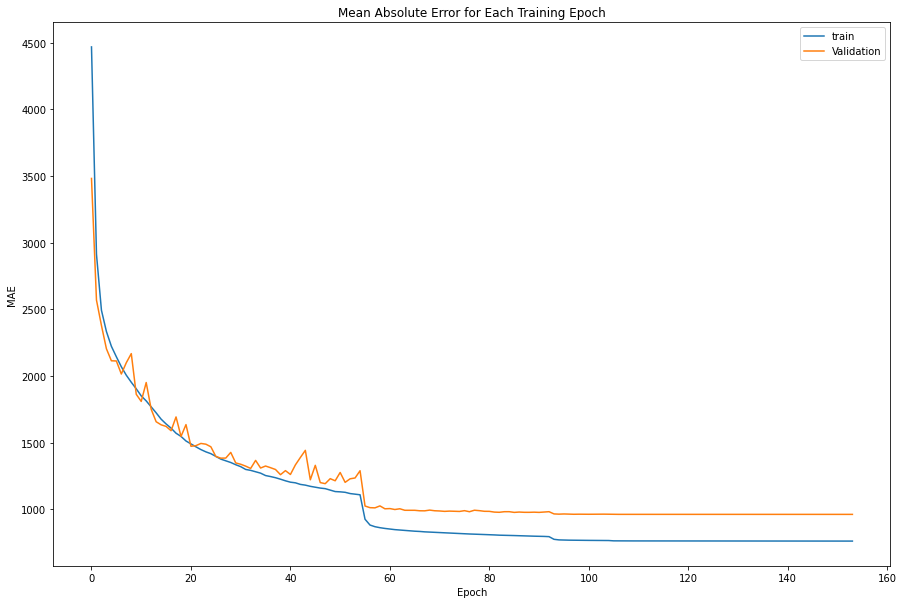

In [77]:
# plot training history
plt.figure(figsize=(15,10))
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='Validation')
plt.title('Mean Absolute Error for Each Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

__Training Observations__
- Model training terminated at 154 epchs with a training time of 53 minutes using premium GPUs.
- No improvement recorded after a learning rate of $1 x {10^-}{^7}$.

In [78]:
%%time
# Evaluating the final NN model
NN_model_3_performance = evaluate_NN(NN_model_3, X_test_ss, y_test, X_train_ss, y_train)

1877/1877 [==============================] - 3s 1ms/step
Model Performance
-----------------
Train set R2 score: 0.9875
Test R2 score: 0.9845
Test set Adjusted R2 score: 0.9845
Test set Root Mean Squared Error - RMSE: 2822.1222
Test set Mean Absolute Error - MAE: 981.0114
Test set Mean Absolute Precentage Error - MAPE: 0.0681
CPU times: user 22.5 s, sys: 2.17 s, total: 24.6 s
Wall time: 19.1 s


We improved the scores and reduced the errors even further and achieved the second best MAPE of 6.81%

In [76]:
# Save the best NN model
joblib.dump(NN_model_3, 'NN_model_3.pkl')

['NN_model_3.pkl']

<div class="alert alert-info">
    
### Conclusion of the NN model
- Model __performed extremely well__ on the dataset and observed almost as good scores as the Random Forest.
- Archived a MAPE below 10%, however, RF still did slightly better.
- Model __did not overfit__ on the training data and generalized well to the unseen data.
- We had to train for 53 minutes even using premium GPUs, CPU training may be too __computationally exhaustive__.
- __Second best candidate__ for predicting flight fate.
- Has the Potential to improve to achieve the best model by making the NN deeper with extra hidden layers.
</div>

---